# Simple decision rules give high performance for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [35]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import pandas as pd


In [36]:
from data_accessor import load_twibot, load_bot_repo_dataset, load_cresci2017, load_cresci2015, load_caverlee, load_emd, load_pan19, load_cresci2017_tweets, load_cresci2015_tweets, load_midterm, load_gilani_derived_bands, load_yang, load_yang_tweets, load_cresci_stock_tweets, tweets_to_countvectorized_df
from preprocess import drop_and_one_hot, extract_users, load_json, preprocess_users, COLUMNS_TO_DROP, DUMMY_COLUMNS
from fit_and_score import fit, score, fit_and_score, kfold_cv, analyze_bot_repo_dataset, analyze_bot_repo_dataset_full, train_test_fit_and_score, nonnumeric, mdi_feature_importance, permutation_feature_importance, plot_metrics, calculate_accuracy


In [37]:
PROJ_PATH = "/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection"


## Load datasets and calculate scores

## Profile data

In [9]:
# Twibot
twibot_df, twibot_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
#twibot_validate, twibot_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")
shared_columns = np.intersect1d(twibot_one_hot.columns, twibot_one_hot_test.columns) # Since we want to check on test set, just use common columns between train/test.
twibot_scores = []
for i in range(1, 6):
    dt_clf = fit(twibot_one_hot[shared_columns], twibot_labels, depth=i)
    scr = score(dt_clf, twibot_one_hot_test[shared_columns], twibot_labels_test, silent=True)
    twibot_scores.append(scr)
    
# botometer-feedback
bf, bf_one_hot, bf_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv")
botometer_feedback_scores = analyze_bot_repo_dataset(bf_one_hot, bf_labels)

#rtbust
rtbust, rtbust_one_hot, rtbust_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json", PROJ_PATH + "/data/cresci-rtbust-2019.tsv")
rtbust_scores = analyze_bot_repo_dataset(rtbust_one_hot, rtbust_labels)

#gilani-2017
gilani, gilani_one_hot, gilani_labels = load_bot_repo_dataset(PROJ_PATH + "/data/gilani-2017_tweets.json", PROJ_PATH + "/data/gilani-2017.tsv")
gilani_scores = analyze_bot_repo_dataset(gilani_one_hot, gilani_labels)

#gilani-2017 with derived features from orginal paper
gilani_derived_dfs, gilani_derived_labels = load_gilani_derived_bands(PROJ_PATH + f"/data/gilani_derived/classification_processed/")
gilani_derived_scores = [analyze_bot_repo_dataset(gilani_derived_df, gilani_derived_label) for gilani_derived_df, gilani_derived_label in zip(gilani_derived_dfs, gilani_derived_labels)]
gilani_derived_scores_avg = [[sum([strat[depth_ind][scr_ind] for strat in gilani_derived_scores])/4 for scr_ind in range(4)] for depth_ind in range(5)]

#cresci-2017
cresci2017, cresci2017_one_hot, cresci2017_labels = load_cresci2017(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv")
cresci2017_scores = analyze_bot_repo_dataset(cresci2017_one_hot, cresci2017_labels)

#cresci-2015
cresci2015, cresci2015_one_hot, cresci2015_labels = load_cresci2015(PROJ_PATH + "/data/cresci-2015/{}/users.csv")
cresci2015_scores = analyze_bot_repo_dataset(cresci2015_one_hot, cresci2015_labels)

#caverlee-2011
caverlee2011, caverlee2011_labels = load_caverlee(PROJ_PATH + "/data/social_honeypot_icwsm_2011/")
caverlee2011_scores = analyze_bot_repo_dataset(caverlee2011, caverlee2011_labels)

#cresci-stock-2018
cresci_stock, cresci_stock_one_hot, cresci_stock_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv")
cresci_stock_scores = analyze_bot_repo_dataset(cresci_stock_one_hot, cresci_stock_labels)

Starting kfold_cv at 1654678330.4381213
Finished kfold_cv at 1654678330.6032274. Execution time: 0.16510605812072754 s
Starting kfold_cv at 1654678330.6034732
Finished kfold_cv at 1654678330.7555437. Execution time: 0.1520705223083496 s
Starting kfold_cv at 1654678330.7556992
Finished kfold_cv at 1654678330.8794496. Execution time: 0.12375044822692871 s
Starting kfold_cv at 1654678330.879666
Finished kfold_cv at 1654678331.0055788. Execution time: 0.12591266632080078 s
Starting kfold_cv at 1654678331.005877
Finished kfold_cv at 1654678331.1339083. Execution time: 0.12803125381469727 s
Starting kfold_cv at 1654678331.206447
Finished kfold_cv at 1654678331.2991364. Execution time: 0.09268951416015625 s
Starting kfold_cv at 1654678331.2993577
Finished kfold_cv at 1654678331.3937166. Execution time: 0.09435892105102539 s
Starting kfold_cv at 1654678331.3939216
Finished kfold_cv at 1654678331.492006. Execution time: 0.0980844497680664 s
Starting kfold_cv at 1654678331.4923143
Finished kfold

In [10]:
midterm, midterm_one_hot, midterm_labels = load_midterm(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json", PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv")
midterm_scores = analyze_bot_repo_dataset(midterm_one_hot, midterm_labels)

Starting kfold_cv at 1654678469.4833682
Finished kfold_cv at 1654678614.7943177. Execution time: 145.3109495639801 s
Starting kfold_cv at 1654678614.7948337
Finished kfold_cv at 1654678806.2130003. Execution time: 191.41816663742065 s
Starting kfold_cv at 1654678806.2138126
Finished kfold_cv at 1654679030.599898. Execution time: 224.3860855102539 s
Starting kfold_cv at 1654679030.6007233
Finished kfold_cv at 1654679285.039405. Execution time: 254.4386818408966 s
Starting kfold_cv at 1654679285.0396512
Finished kfold_cv at 1654679576.9677415. Execution time: 291.9280903339386 s


In [11]:
yang, yang_one_hot, yang_labels = load_yang(PROJ_PATH + "/data/yang-2013/")
yang_scores = analyze_bot_repo_dataset(yang_one_hot, yang_labels)

Starting kfold_cv at 1654679579.1236248
Finished kfold_cv at 1654679603.5436456. Execution time: 24.420020818710327 s
Starting kfold_cv at 1654679603.5443482
Finished kfold_cv at 1654679632.7997751. Execution time: 29.25542688369751 s
Starting kfold_cv at 1654679632.8004792
Finished kfold_cv at 1654679666.281109. Execution time: 33.48062992095947 s
Starting kfold_cv at 1654679666.2818139
Finished kfold_cv at 1654679702.740826. Execution time: 36.459012031555176 s
Starting kfold_cv at 1654679702.741537
Finished kfold_cv at 1654679742.5621338. Execution time: 39.82059669494629 s


## Tweets data

In [5]:
yang_tweets, yang_tweets_labels = load_yang_tweets(PROJ_PATH + "/data/yang-2013/")
yang_tweets_scores = analyze_bot_repo_dataset(yang_tweets, yang_tweets_labels)

Starting kfold_cv at 1654675568.2498243
Finished kfold_cv at 1654675592.4868712. Execution time: 24.23704695701599 s
Starting kfold_cv at 1654675592.487556
Finished kfold_cv at 1654675621.698066. Execution time: 29.21051001548767 s
Starting kfold_cv at 1654675621.698193
Finished kfold_cv at 1654675655.3349152. Execution time: 33.63672208786011 s
Starting kfold_cv at 1654675655.3350492
Finished kfold_cv at 1654675692.5804856. Execution time: 37.24543642997742 s
Starting kfold_cv at 1654675692.5812068
Finished kfold_cv at 1654675732.2659607. Execution time: 39.68475389480591 s
Starting kfold_cv at 1654675850.5375926
Finished kfold_cv at 1654675876.8338163. Execution time: 26.296223640441895 s
Starting kfold_cv at 1654675876.8343444
Finished kfold_cv at 1654675918.5690806. Execution time: 41.73473620414734 s
Starting kfold_cv at 1654675918.5696073
Finished kfold_cv at 1654675972.691108. Execution time: 54.121500730514526 s
Starting kfold_cv at 1654675972.691632
Finished kfold_cv at 165467

In [4]:
pan19_df, pan19_labels = load_pan19(PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/{}.xml", PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/truth.txt")
pan19_scores = analyze_bot_repo_dataset(pan19_df, pan19_labels)


In [ ]:
cresci2017_tweets, cresci2017_tweets_labels = load_cresci2017_tweets(PROJ_PATH + "/data/cresci-2017/{}.csv/tweets.csv")
cresci2017_tweets_scores = analyze_bot_repo_dataset(cresci2017_tweets, cresci2017_tweets_labels)


/home/jhays/bot-detection/data_accessor.py:224: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')
/home/jhays/bot-detection/data_accessor.py:224: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')
/home/jhays/bot-detection/data_accessor.py:224: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')
/home/jhays/bot-detection/data_accessor.py:224: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')
/home/jhays/bot-detection/data_accessor.py:224: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option

Starting kfold_cv at 1654629165.9690356
Finished kfold_cv at 1654629278.761959. Execution time: 112.79292345046997 s
Starting kfold_cv at 1654629278.7626636
Finished kfold_cv at 1654629447.7766688. Execution time: 169.01400518417358 s
Starting kfold_cv at 1654629447.777259


In [5]:
cresci2015_tweets, cresci2015_tweets_labels = load_cresci2015_tweets(PROJ_PATH + "/data/cresci-2015/{}/tweets.csv")
cresci2015_tweets_scores = analyze_bot_repo_dataset(cresci2015_tweets, cresci2015_labels)


/home/jhays/bot-detection/data_accessor.py:255: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')


Starting kfold_cv at 1654626317.7949297
Finished kfold_cv at 1654626370.664954. Execution time: 52.87002420425415 s
Starting kfold_cv at 1654626370.665665
Finished kfold_cv at 1654626451.4402087. Execution time: 80.77454376220703 s
Starting kfold_cv at 1654626451.4409568
Finished kfold_cv at 1654626543.3047235. Execution time: 91.86376667022705 s
Starting kfold_cv at 1654626543.3054848
Finished kfold_cv at 1654626647.666441. Execution time: 104.3609561920166 s
Starting kfold_cv at 1654626647.6671922
Finished kfold_cv at 1654626762.499904. Execution time: 114.83271169662476 s


In [ ]:
cresci_stock_tweets, cresci_stock_tweets_labels = load_cresci_stock_tweets(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv", PROJ_PATH + "/data/golbeck/tweets/{}_tweets.csv")
cresci_stock_tweets_scores = analyze_bot_repo_dataset(cresci_stock_tweets, cresci_stock_tweets_labels)


Starting kfold_cv at 1654677137.1003506


## Only account ids

In [6]:
varol = np.loadtxt(PROJ_PATH + "/data/varol-2017.dat", unpack=True)
kaiser = pyreadr.read_r(PROJ_PATH + '/data/kaiser/data_botometer.RData')['data_botometer']

# Single-class datasets

In [36]:
# bot-wiki
botwiki_df, botwiki_one_hot, botwiki_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botwiki-2019_tweets.json", PROJ_PATH + "/data/botwiki-2019.tsv")
# celebrity
celebrity_df, celebrity_one_hot, celebrity_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/celebrity-2019.tsv")
# political-bots
political_bots_df, political_bots_one_hot, political_bots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json", PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")
# pronbots
pronbots_df, pronbots_one_hot, pronbots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/pronbots-2019.tsv")
# vendor purchased
vendor_purchased_df, vendor_purchased_one_hot, vendor_purchased_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/vendor-purchased-2019.tsv")
# EMD
emd, emd_labels = load_emd(PROJ_PATH + '/data/EMD-2017/Twitter_dataset.arff') # Load data

## Analysis of each of the specialized classifiers in Botometer

### humans

In [ ]:
human_df = pd.concat([caverlee2011_humans], axis=0)

### simple bots

In [20]:
simple_df = caverlee2011_bots

### spammers

In [28]:
# Load in cresci data
folder_names = [ 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
dfs = []

for name in folder_names:
    df = pd.read_csv(f"./data/cresci-2017/{name}.csv/users.csv")
    dfs.append(df)

    
def format_time(dt):
    try:
        datetime.strptime(dt, "%a %b %d %H:%M:%S %z %Y").timestamp()
    except:
        print(dt)
    
cresci2017_spammers = pd.concat(dfs)



# Preprocess
cresci2017_one_hot = preprocess(cresci2017_spammers, 
                        COLUMNS_TO_DROP + ['profile_banner_url', 
                                                        'test_set_1', 
                                                        'test_set_2', 
                                                        'crawled_at',
                                                        'updated', 
                                                        'timestamp',
                                                        'following', 
                                                        'follow_request_sent',
                                                        'created_at'
                                                  ], 
                        DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications'])

spammers_df = pd.concat([pronbots_one_hot, cresci2017_one_hot], ignore_index=True)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

### fake followers

### self-declared

### political bots

### other bots

# Plotting performance of network stats on single plot

In [41]:
caverlee2011_scores

[[0.7653196567448248,
  0.9987098953890051,
  0.5624640225895776,
  0.7196203978249585],
 [0.9052266741384141,
  0.9091619698194414,
  0.914456620968197,
  0.9117876743053633],
 [0.9059736737043366,
  0.9102564848870367,
  0.9146102917986008,
  0.912409264412952],
 [0.9284561037256631,
  0.9318203824652074,
  0.9348549629938601,
  0.9333163812048617],
 [0.9322874783868574,
  0.9242900418635148,
  0.951527377105875,
  0.9376941751010499]]

In [38]:
scores_dict = {
    "twibot": {
        "a": 0.8664, #accuracy
        "p": 0.8256, #precision
        "r": 0.8657, #recall
        'scores': twibot_scores
    },
    "botometer-feedback-2019": {
        'a': 0.81,
        "p": 0.84,
        "r": 0.7,
        'num_bots': 139,
        'num_humans': 380,
        'scores': botometer_feedback_scores
    },
    "rtbust": {
        "a": 0.8755,
        'p': 0.9304,
        'r': 0.9512,
        'scores': rtbust_scores
    },
    "midterm-2018": {
        "a": 0.987,
        'p': 0.989,
        'r': 0.995,
        'scores': midterm_scores
    },
    "gilani": {
        "a": 0.8644,
        'p': 0.854,
        'r': 0.822,
        'scores': gilani_derived_scores_avg
    },
    "cresci-2017": {
        'a': 0.9871,
        'p': 0.98,
        'r': 0.98,
        'scores': cresci2017_scores
    },
    "cresci-2015": {
        "a": 0.991,
        'p': 0.994,
        'r': 0.991,
        'scores': cresci2015_scores
    },
    "caverlee-2011": {
        'a': 0.9826,
        'p': 0.89,
        'r': 0.87,
        'num_bots': 19276,
        'num_humans': 22223,
        'scores': caverlee2011_scores
    },
}
metric_names = ['accuracy', 'F1', 'precision', 'recall']

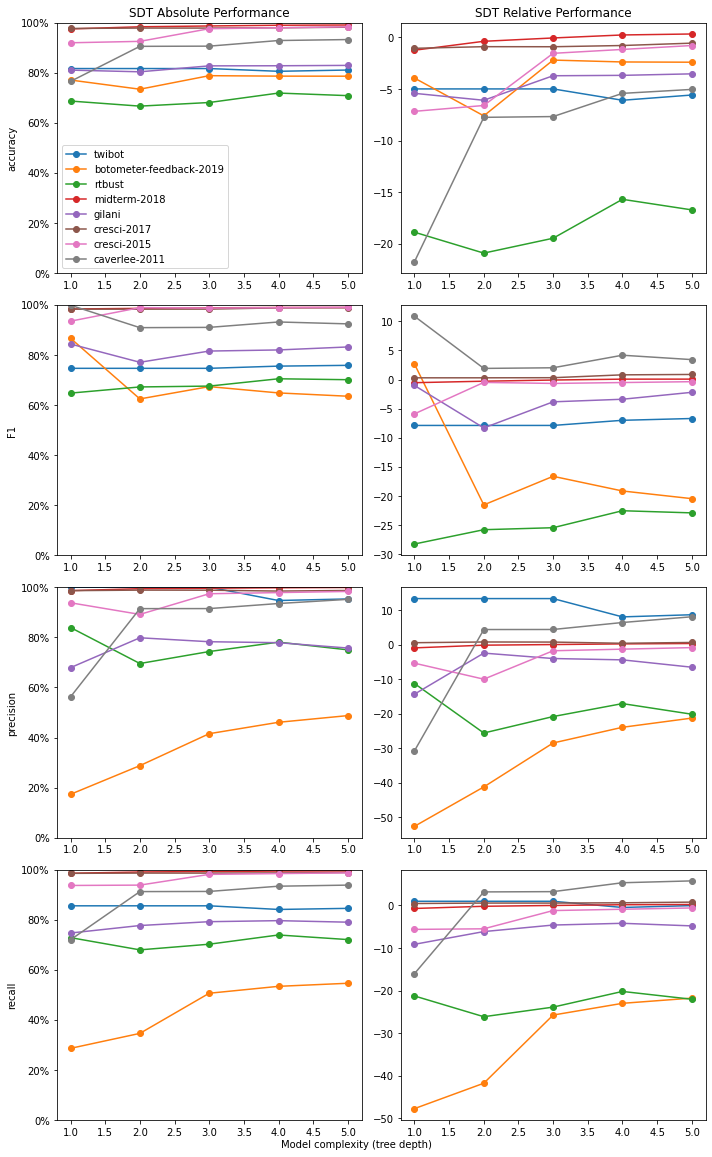

In [39]:
fig, axes = plt.subplots(4,2, figsize=(10, 16))

for i, metric_name in enumerate(metric_names):
    for name, d in scores_dict.items():
#         if (name in ['gilani', 'botometer-feedback-2019', 'rtbust']):
#             continue
        if i == 0:
            if 'a' in d:
                soa_score = d['a']
            else:
                soa_score = calculate_accuracy(d['p'], d['r'], d['num_bots'], d['num_humans'])
        if i == 1:
            soa_score = d['p']
        if i == 2:
            soa_score = d['r']
        if i == 3:
            d['f'] = 2 * (d['p'] * d['r']) / (d['p'] + d['r'])
            soa_score = d['f']
        #print(name, d['scores'])
        metric_i = [item[i]*100 for item in d['scores']]
        axes[i][0].plot(range(1,6), metric_i, label=name, marker="o")
        metric_i_relative = [(item[i]-soa_score)*100 for item in d['scores']]
        axes[i][1].plot(range(1,6), metric_i_relative, label=name, marker="o")
        metric_i_max = max([item[i] for item in d['scores']])
        delta_i = metric_i_max - soa_score
        d["sdt_"+metric_name] = metric_i_max
        d["sdt_delta_"+metric_name] = delta_i
    axes[i][0].set_ylabel(metric_name)
    axes[i][0].set_ylim((0,100))
    yticks = mtick.PercentFormatter(is_latex=True)
    axes[i][0].yaxis.set_major_formatter(yticks)
axes[0][0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
axes[0][0].set_title("SDT Absolute Performance")
axes[0][1].set_title("SDT Relative Performance")
fig.tight_layout()
plt.show()

score_df = pd.DataFrame.from_dict(scores_dict, orient="index")
score_df.to_csv("bot_detection_scores.csv")